# Data Analysis

This notebook analyses the results of the element categorization and area calculation from the last two notebooks. The bulk of findings in our methodlogy paper are found here:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import os
import sys
import json
import time
import glob
import tempfile
import warnings
import inspect
from typing import Dict, List
from collections import Counter
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.display import display

sys.path.append("..")
from utils.config import (
    google_domains,
    cat2color
)

In [4]:
# variables
use_full_dataset = False
data_dir = '../data' if use_full_dataset else '../data_subsample'

In [5]:
# input
fn_metadata = f'{data_dir}/intermediary/element_metadata.jsonl.gz'

# output
output_dir = f'{data_dir}/output'
tables_dir = os.path.join(output_dir, 'tables/')
figure_dir = os.path.join(output_dir, 'figures/')
appendix_dir = os.path.join(output_dir, 'appendix/')

for d in [tables_dir, figure_dir, appendix_dir]:
    os.makedirs(d, exist_ok=True)

In [6]:
df = pd.read_json(fn_metadata, 
                  lines=True, 
                  compression='gzip')

In [7]:
# recall a record looks like this
df.sample(1).iloc[-1].to_dict()

{'text': 'Products',
 'link': None,
 'domain': 'google.com',
 'xpath': '/html/body/div[10]/div/div[6]/div/div[3]/div/div[6]/div/g-tabs/div/div[1]/a[2]',
 'category': 'link-knowledge_panel_tab',
 'tag': 'a',
 'attrs': {'jsname': 'AznF2e',
  'class': ['KYeOtb', 'ih2ainT7gdI__unselected', 'M51USb'],
  'aria-selected': 'false',
  'data-index': '1',
  'style': 'height:48px;color:#5F6368;border-color:#6E7275;padding:0 16px',
  'tabindex': '-1',
  'role': 'tab',
  'jsaction': 'h5M12e'},
 'dimensions': {'height': 48.0, 'width': 174.9499969482},
 'location': {'x': 180, 'y': 1905},
 'area_page': 8397.5998535136,
 'fn_input': '../data/input/google_search/iPhone-X/2019/12/08/Tenda/html/webpage_raw.html',
 'position_last_element': 5162,
 'fn_metadata': '../data_subsample/intermediary/google_search/iPhone-X/2019/12/08/Tenda/json/parsed_meta.jsonl',
 'q1_area': 0.0,
 'q2_area': 0.0,
 'q3_area': 0.0,
 'q4_area': 0.0,
 'q5_area': 0.0,
 'q6_area': 0.0,
 'q7_area': 0.0,
 'q8_area': 0.0,
 'q9_area': 0.0,


In [8]:
total_area = df.area_above_the_fold.sum()
total_area_fp = df.area_page.sum()

In [9]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Non-Google',
    'amp' : 'AMP',
    'ads' : 'Ads'
}

\begin{equation}
X_{g} = \frac{g}{g + ng + amp + ad}
\end{equation}



Where <br>
&nbsp;&nbsp;&nbsp;&nbsp; $X_{g}$: is the percentage of real estate that occupied by Google.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $g$: is the sum of real estate pixels occupied by Google products and answers.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $ng$: is the sum of real estate pixels occupied by Non-Google.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $amp$: is the sum of real estate pixels occupied by AMP.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $ad$: is the sum of real estate pixels occupied by ads.<br>

## Breakdown of area and frequency for each category
For a more granular look at how much space is occupied by each search feature:

In [10]:
table_cols = [
   ('First Screen', 'area'),
   ('First Screen' , 'area'),
   ('Full page', 'freq'),
   ('Full page' , 'area'),
]

In [11]:
total_area = df.area_above_the_fold.sum()
total_area_fp = df.area_page.sum()
n_pages = df.fn_input.nunique()

## Table 1

In [12]:
fn_cats = f'{data_dir}/output/tables/T1_area_freq_by_category.csv'

In [13]:
data = {}
for label in df.label.unique():
    _df = df[df.label == label]
    area = (_df['area_above_the_fold'].sum() / total_area)
    freq = _df[_df['area_above_the_fold'] != 0].fn_input.nunique() / n_pages
    
    area_page = (_df['area_page'].sum() / total_area_fp)
    freq_page = _df[_df['area_page'] != 0].fn_input.nunique() / n_pages
    
    data[label2publabel.get(label,label)] = {
        ('First Screen', 'area') : area,
        ('First Screen', 'freq') : freq,
        ('First page', 'area') : area_page,
        ('First page', 'freq') : freq_page,
    }
    
cat_breakdown = pd.DataFrame(data).T
cat_breakdown.columns = pd.MultiIndex.from_tuples(table_cols)

print((cat_breakdown * 100).round(1).astype(str) + '%')

               First Screen        Full page        
                       area   area      freq    area
Google Answer         25.1%  70.8%     13.4%   98.8%
Google Product        37.0%  93.8%     27.2%  100.0%
Non-Google            20.1%  80.0%     45.9%  100.0%
AMP                   11.6%  21.2%     12.6%   74.5%
Ads                    6.3%   8.0%      1.0%    9.2%


In [14]:
cat_breakdown.to_csv(fn_cats)

In [15]:
fn_pixels = f'{data_dir}/intermediary/pixels_above_the_fold.csv'
fn_pixels_page = f'{data_dir}/intermediary/pixels_page.csv'

In [16]:
labels_in_order = [
    'organic',
    'amp',
    'answer',
    'link',
    'ads'
]

In [17]:
area_cols = ['area_above_the_fold', 'area_page']

In [18]:
if os.path.exists(fn_pixels) and os.path.exists(fn_pixels_page):
    df_pixels = pd.read_csv(fn_pixels)
    df_pixels_fp = pd.read_csv(fn_pixels_page)
    
else:
    pixels = {c : list() for c in area_cols}
    for search, df_ in tqdm(df.groupby('fn_input'), position=0, leave=True):
        for col in area_cols:
            # get sum of pixels for each label.
            ad = df_[df_.label == 'ads'][col].sum()
            o = df_[df_.label == 'organic'][col].sum()
            g = df_[(df_.label == 'link') | (df_.label == 'answer')][col].sum()
            a =  df_[df_.label == 'answer'][col].sum()
            amp = df_[df_.label == 'amp'][col].sum()

            # equations
            e1 =  o / (g + ad + o + amp)
            e2 = g / (g + ad + o + amp)

            row = {
                'search_term' : search,
                'ad' : ad,
                'ng' : o,
                'g' : g,
                'a' : a,
                'amp' : amp,
                'e1' : e1,
                'e2' : e2,
            }

            pixels[col].append(row)

    df_pixels = pd.DataFrame(pixels['area_above_the_fold'])
    df_pixels_fp = pd.DataFrame(pixels['area_page'])

    df_pixels.e1.fillna(0, inplace=True)
    df_pixels.e2.fillna(0, inplace=True)
    
    df_pixels.to_csv(fn_pixels, index=False)
    df_pixels_fp.to_csv(fn_pixels_page, index=False)

## Histogram of Google-occupied pixels

In [19]:
def hist(series, color='black', 
         title=None, 
         fn_out=None,
         left_right_annotations = (None, None)):
    """Creates a histogram for a given series"""
    ax = series.plot(kind='hist', 
                           figsize=(10,6),
                           bins=10, 
                           rwidth=.95,
                           color=color,
                           alpha=.9,
                           title=title)

    ax.tick_params(axis="both", which="both", bottom="off", 
                   top="off", labelbottom="on", left="off", 
                   right="off", labelleft="on")

    plt.annotate(left_right_annotations[0], 
                 (0.04, 0), (0, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')
    plt.annotate(left_right_annotations[-1], 
                 (.75, 0), (.75, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')

    ax.set_ylabel("Count of search pages")

    ax.set_axisbelow(True)
    plt.gca().yaxis.grid(True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if fn_out:
         plt.savefig(fn_out)
    
    return ax

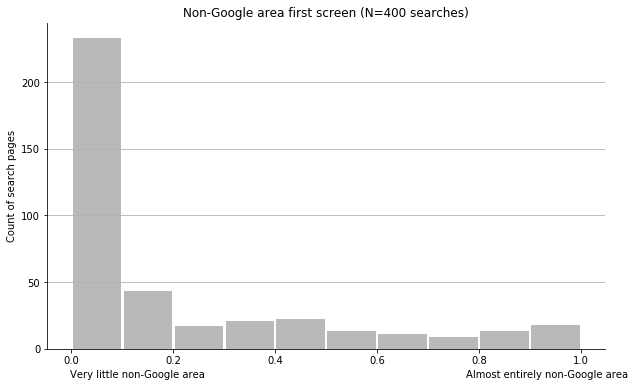

In [20]:
hist(df_pixels.e1,
     left_right_annotations = ('Very little non-Google area',
                               'Almost entirely non-Google area'),
     color=cat2color['organic'],
     title = f'Non-Google area first screen (N={len(df_pixels):,} searches)',
     fn_out='../data/output/figures/eq1_abv.png');

In [21]:
# What percentage of pages have 10% or less of the page occupied by Non-Google?
len(df_pixels[df_pixels.e1 <= .1]) / len(df_pixels) * 100

58.25

In [22]:
df_pixels.e1.mean(), df_pixels.e1.median()

(0.20060110647001203, 0.04491235682788)

In [23]:
# what is the standard error?
(df_pixels.e1.sem()) * 100

1.4312050779916208

What about the full page?

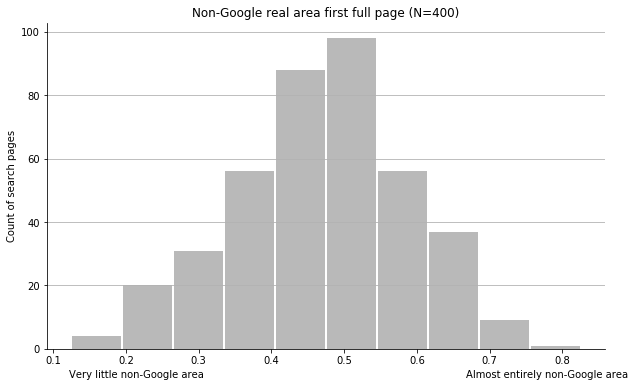

In [24]:
hist(df_pixels_fp.e1,
     title=f'Non-Google real area first full page (N={len(df_pixels):,})',
     left_right_annotations = ('Very little non-Google area',
                               'Almost entirely non-Google area'),
     color=cat2color['organic'],
     fn_out='../data/output/figures/eq1_page.png');

In [25]:
# What percentage of pages have 50% or more of the page occupied by non-Google?
len(df_pixels_fp[df_pixels_fp.e1 >= .5]) / len(df_pixels) * 100

41.5

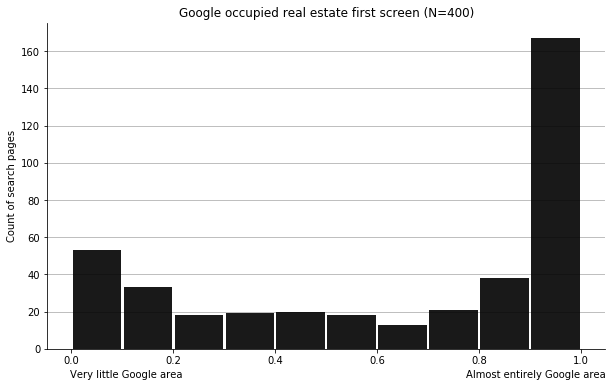

In [26]:
hist(df_pixels.e2,
     color='k',
     title = f'Google occupied real estate first screen (N={len(df_pixels):,})',
     left_right_annotations=('Very little Google area',
                               'Almost entirely Google area'),
     fn_out='../data/output/figures/eq2_above.png')

In [27]:
# What percentage of pages have 90% or more of the page occupied by Google?
len(df_pixels[df_pixels.e2 >= .9]) / len(df_pixels) * 100

41.75

## Figure 2
Like the histogram above, lets bin the data to show the distribution of area coverage per category in our sample:

In [28]:
fn_fig2 = os.path.join(figure_dir, '2-normalized-bar.png')
fn_fig2_data = os.path.join(figure_dir, '2-normalized-bar.csv')

In [29]:
non_google_bins = (pd.cut(df_pixels.e1, bins=4).value_counts() / 
                   n_pages).sort_index()
non_google_bins

(-0.001, 0.25]    0.7225
(0.25, 0.5]       0.1175
(0.5, 0.75]       0.0750
(0.75, 1.0]       0.0850
Name: e1, dtype: float64

In [30]:
google_bins = (pd.cut(df_pixels.e2, bins=4).value_counts() / 
               n_pages).sort_index()
google_bins

(-0.001, 0.25]    0.2375
(0.25, 0.5]       0.1200
(0.5, 0.75]       0.0950
(0.75, 1.0]       0.5475
Name: e2, dtype: float64

In [31]:
cmap = plt.cm.get_cmap('gray_r')
colors = iter(cmap(np.linspace(0.2,.7,4)))
labels = [
    '\nLittle or No Coverage\n[0, 25%] of area',
    '\nSome Coverage\n(25, 50%]',
    '\nMore Coverage\n(50, 75%]',
    '\nAlmost Entirely Covered\n(75, 100%]'
]
legend_elements_bar = [Line2D([0], [0], marker='s', color='w', 
                          label=labels[i],
                          markerfacecolor=c, markersize=10)
                   for i, c in enumerate(colors)][::-1]

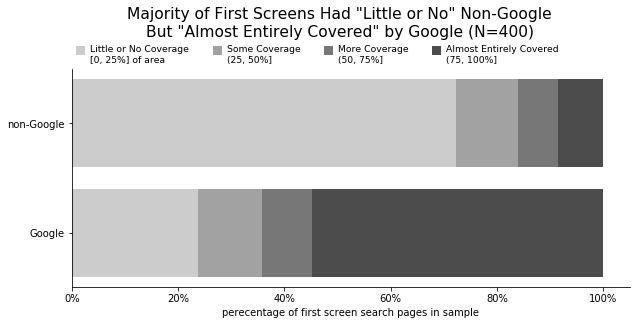

In [32]:
cmap = plt.cm.get_cmap('gray_r')
colors = iter(cmap(np.linspace(0.2,.7,4)))

colors_g = iter(cmap(np.linspace(0.2,.7,4)))

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,4))

# Set bar width at 1
bar_width = 1
_google = google_bins.values
_non_google = non_google_bins.values
for i, data in enumerate(_google):
    if i != 0:
        ax.barh('Google', data, 
                left=sum(_google[:i]),
                 linewidth=0,
                 color=next(colors_g)
               );
    else:
        ax.barh('Google', data,
               color=next(colors_g)
               );
        
for i, data in enumerate(_non_google):
    if i != 0:
        ax.barh('non-Google', data, color=next(colors), left=sum(_non_google[:i]));
    else:
        ax.barh('non-Google', data, color=next(colors))

plt.title(f'Majority of First Screens Had "Little or No" Non-Google\n'
          f'But "Almost Entirely Covered" by Google (N={len(df_pixels):,})',
           x=0.48,
         y=1.125,
         size=15.5)
        
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))


plt.xlabel('perecentage of first screen search pages in sample')
ax.legend(handles=legend_elements_bar[::-1],
          loc='lower left', 
          bbox_to_anchor= (-0.005, 1.015), ncol=4,
          handletextpad=0.1,
          labelspacing=0, 
          borderaxespad=.1, 
          borderpad=0.1,
          frameon=False,
          prop={'size': 9.2})

plt.savefig(fn_fig2)
plt.show();

In [33]:
merged = pd.DataFrame(google_bins).join(pd.DataFrame(non_google_bins))
merged.columns = ['Googe', 'Non-Google']
merged.to_csv(fn_fig2_data)

## Distance Plot

In [34]:
fn_fig3 = os.path.join(figure_dir, '3-distance_normalized.png')
fn_fig3_data = os.path.join(figure_dir, '3-distance_normalized.csv')

In [35]:
df.loc[:, 'y_dist'] = df.location.apply(lambda x: x['y'])

In [36]:
df.loc[df['category'] == 'link-youtube', 
       "category_standard"] = 'youtube'
df.loc[df['category'] == 'link-youtube_search_result', 
       "category_standard"] = 'youtube-search-result'

In [37]:
blue_link_categories = [
    'organic-search_result',
    'amp-search_result',
    "youtube-search-result"
]

In [38]:
standard_categories = [
    "organic-search_result",
    "organic",
    "ads",
    "amp-card",
    "amp-visual_stories",
    "google-images",
    "youtube",
    "google-maps",
    'google-answer',
    "google-search",
    "amp-search_result",
    "youtube-search-result",
]

In [39]:
cat2name = {
    "ads" : 'Ad',
    "organic" : 'non-\nGoogle\nLink',
    "amp-card" : 'AMP\nArticle',
    "amp-visual_stories" : "AMP\nStory",
    "google-images" : 'Google\nImages',
    "youtube": 'YouTube',
    "google-maps" : 'Google\nMaps',
    'google-answer' : 'Direct\nAnswer',
    'google-search' : 'Google\nSearch',
    "organic-search_result" : 'non-\nGoogle\nTrad-\nitional\nResult'
}

In [40]:
df.category_standard.value_counts()

google-search                   7496
google-answer                   3450
google-misc                     2968
organic                         2903
organic-search_result           2890
google-images                   2580
google-expandable-answer        2505
youtube                         1892
google-knowledge-panel-links    1553
amp-card                        1264
amp-search_result                935
ads                              149
google-maps                       55
google-video                      32
youtube-search-result             30
amp-visual_stories                22
Name: category_standard, dtype: int64

Here we get distance down the page we'd have to for before seeing specific search features (`standard_categories`).

Note, we normalize the length down a page between 0 (below the search bar and headers) and 1 (below the "More results" button).

In [41]:
header = 160
normalize = True

In [42]:
if not os.path.exists(fn_fig3_data):
    dist = {k : [] for k in standard_categories}
    for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
        end_of_page = _df['position_last_element'].iloc[0] - header
        for cat in standard_categories:
            # a tweak for blue links.
            _df.category_standard = _df.category_standard.replace({'amp-search_result' :'organic-search_result',
                                                                   'youtube-search-result' : 'organic-search_result'})
            __df = _df[_df.category_standard == cat]
            if not __df.empty:
                # normalized page
                if normalize:
                    y_min = (__df.y_dist.min() - header) / end_of_page
                else:
                    y_min =__df.y_dist.min()
                dist[cat].append(y_min)

    for k in ['amp-search_result', 'youtube-search-result']:
        dist.pop(k)

    data = []
    for cat, v in dist.items():
        _dist = pd.DataFrame({'dist_y' : v}).dist_y
        mean = _dist.mean()
        median = _dist.median()
        err = _dist.sem()
        std = _dist.std()
        data.append({
            'category' : cat,
            'dist_mean' : mean,
            'min' : _dist.describe()['min'],
            '25' : _dist.describe()['25%'],
            '50' : _dist.describe()['50%'],
            '75' : _dist.describe()['75%'],
            'max' : _dist.describe()['max'],
            'std' : std,
            'sem_error' : err,
            'n' : len(v)
        })
    df_dist = pd.DataFrame(data)
    del data

else:
    df_dist = pd.read_csv(fn_fig3_data)

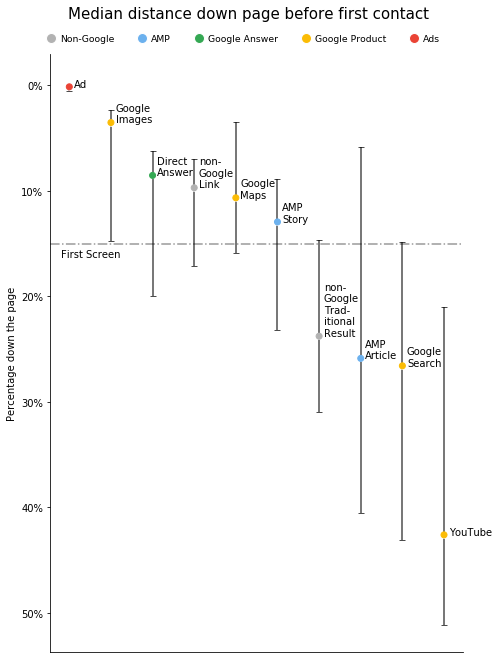

In [43]:
legend_elements_dist = [Line2D([0], [0], marker='o', color='w', 
                          label=label2publabel.get(label),
                          markerfacecolor=c, markersize=10)
                        for label, c in cat2color.items()][::-1]

fig, ax = plt.subplots(figsize=(7.4, 11))
col = '50'
data = df_dist.sort_values(by=col)
labels = [cat.replace('google-answer', 'answer')
                            .replace('google-expandable-answer', 'answer')
                            .split('-')[0]
                            .replace('google', 'link')
                            .replace('youtube', 'link') for cat in data.category]

colors = [cat2color.get(label) for label in labels]


plt.scatter(data.category, data[col], 
            c=colors, zorder=100)

plt.errorbar(data.category, col, 
             data=data,
             yerr=[data[col] - data['25'], 
                   data['75']- data[col]], 
             ecolor='k', color='white',
             capsize = 3,  fmt='o',
             alpha=.7)

plt.gca().invert_yaxis()
plt.axhline(y=.15, color='black', linestyle='-.', alpha=.4)
# plt.annotate('Top of Page', (8, .143))
plt.annotate('First Screen', (-.2, .163))


plt.xticks(rotation=90)
for i, (_, row) in enumerate(data.iterrows()):
    txt = row['category']
    x = i + .11
    y = row[col]
    plt.annotate(cat2name.get(txt, txt), 
                 (x, y), 
                 ha='left',
                 zorder=200)


ax.set_ylabel("Percentage down the page")

ax.legend(handles=legend_elements_dist[::-1],
          loc='lower left', 
          bbox_to_anchor= (-0.025, 1.015), ncol=5,
          handletextpad=0.0,
          labelspacing=0, 
          borderaxespad=.1, 
          borderpad=0.1,
          frameon=False,
          prop={'size': 9.2}
         )

plt.title('Median distance down page before first contact',
         x=0.48,
         y=1.05,
         size=15.)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set_axisbelow(True)
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_visible(False)

plt.savefig(fn_fig3)
del data;
plt.show();

In [44]:
df_dist.loc[:, "descriptive_name"] = df_dist.category.replace(cat2name).str.replace('\n', ' ').str.replace('non- ', 'non-').str.replace('Trad- ', 'Trad')

In [45]:
df_dist.to_csv(fn_fig3_data, index=False)

## Stacked Area Plot

In [46]:
n_quantiles = 50

In [47]:
fn_out = f'{data_dir}/output/figures/4-soup.csv'
fn_plt = f'{data_dir}/output/figures/4-soup.png'

In [48]:
area_cols = [f'q{i+1}_area' for i in range(0, n_quantiles)]

In [49]:
labels_in_order = [
    'ads',
    'link',
    'answer',
    'amp',
    'organic',
][::-1]

label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Organic',
    'amp' : 'AMP',
    'ads' : 'Ads'
}

label2label = {
    'organic' : 'Non-Google',
    'amp' : 'AMP',
    'answer' : 'Google Answer',
    'link' : 'Google Product',
    'ads' : "Ads",
}

In [50]:
data = []
for q in tqdm(area_cols):
    _df = df[df[q] > 0]
    total_area = _df[q].sum()
    row = {'quantile' : q.replace('_area', '')}
    for label in labels_in_order:
        __df = _df[_df.label == label]
        area = (__df[q].sum() / total_area)
        freq = __df.fn_input.nunique() / n_pages
        row['area', label2publabel.get(label,label)] = area
        row['freq', label2publabel.get(label,label)] = freq
    data.append(row)

100%|██████████| 50/50 [00:00<00:00, 141.48it/s]


In [51]:
quantiles = pd.DataFrame(data)
quantiles.set_index('quantile', inplace=True)
quantiles.columns = pd.MultiIndex.from_tuples(quantiles.columns)

In [52]:
quantiles.loc[:,quantiles.columns.get_level_values(0) == 'area']

area                                                 
           Organic       AMP Google Answer Google Product       Ads
quantile                                                           
q1        0.194357  0.003946      0.085335       0.602994  0.113368
q2        0.166013  0.054642      0.107274       0.580415  0.091656
q3        0.154081  0.164649      0.149886       0.447989  0.083395
q4        0.172171  0.187047      0.346454       0.222545  0.071782
q5        0.186035  0.188148      0.400082       0.187373  0.038364
q6        0.228340  0.122937      0.382815       0.230544  0.035364
q7        0.275636  0.071823      0.283594       0.342175  0.026773
q8        0.321621  0.047101      0.218558       0.395187  0.017533
q9        0.328110  0.053032      0.195498       0.415731  0.007629
q10       0.368628  0.071600      0.204906       0.344894  0.009972
q11       0.376474  0.081902      0.229130       0.309123  0.003371
q12       0.418811  0.082498      0.213188       0.284329  0.001174
q13       0.425123  0.108080      0.199935       0.266861  0.000000
q14       0.460156  0.119274      0.191647       0.228923  0.000000
q15       0.536493  0.111456      0.159620       0.192432  0.000000
q16       0.600845  0.104377      0.088988       0.205790  0.000000
q17       0.582943  0.108665      0.090549       0.217844  0.000000
q18       0.574634  0.105951      0.095400       0.224016  0.000000
q19       0.556369  0.109845      0.105327       0.228460  0.000000
q20       0.571427  0.120897      0.101786       0.205891  0.000000
q21       0.540230  0.145113      0.104313       0.210343  0.000000
q22       0.509474  0.136251      0.120972       0.233303  0.000000
q23       0.501335  0.121179      0.121883       0.255603  0.000000
q24       0.492391  0.103198      0.135561       0.268850  0.000000
q25       0.474951  0.108549      0.151295       0.265205  0.000000
q26       0.474904  0.113702      0.154863       0.256531  0.000000
q27       0.505868  0.103869      0.141737       0.248525  0.000000
q28       0.552513  0.095174      0.122754       0.229559  0.000000
q29       0.565219  0.124482      0.108904       0.201395  0.000000
q30       0.617769  0.122886      0.088850       0.170495  0.000000
q31       0.662750  0.140043      0.073107       0.124100  0.000000
q32       0.671160  0.176541      0.048675       0.103624  0.000000
q33       0.670372  0.193812      0.043044       0.092772  0.000000
q34       0.689577  0.211582      0.026734       0.072107  0.000000
q35       0.721132  0.208971      0.020560       0.049337  0.000000
q36       0.740694  0.194710      0.025192       0.039405  0.000000
q37       0.764191  0.186813      0.017612       0.031385  0.000000
q38       0.727212  0.226235      0.011215       0.035338  0.000000
q39       0.690930  0.255109      0.018763       0.033865  0.001334
q40       0.686874  0.247022      0.021107       0.042252  0.002743
q41       0.649197  0.235304      0.034162       0.076134  0.005203
q42       0.618797  0.212781      0.043678       0.119806  0.004939
q43       0.595654  0.183816      0.063153       0.151171  0.006206
q44       0.415719  0.108055      0.106709       0.360092  0.009424
q45       0.208769  0.066564      0.183720       0.536387  0.004561
q46       0.081023  0.022363      0.433009       0.459004  0.004602
q47       0.020713  0.005829      0.415052       0.558407  0.000000
q48       0.008431  0.003978      0.229740       0.757852  0.000000
q49       0.008059  0.002463      0.094917       0.894560  0.000000
q50       0.001345  0.000857      0.026642       0.971157  0.000000

In [53]:
cuts = quantiles.loc[:,quantiles.columns.get_level_values(0) == 'area']
cuts.columns = cuts.columns.droplevel()

In [54]:
cuts.to_csv(fn_out)

In [55]:
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label2label.get(label),
                          markerfacecolor=c, markersize=10)
                   for label, c in cat2color.items()][::-1]
colors = [cat2color.get(c) for c in labels_in_order]

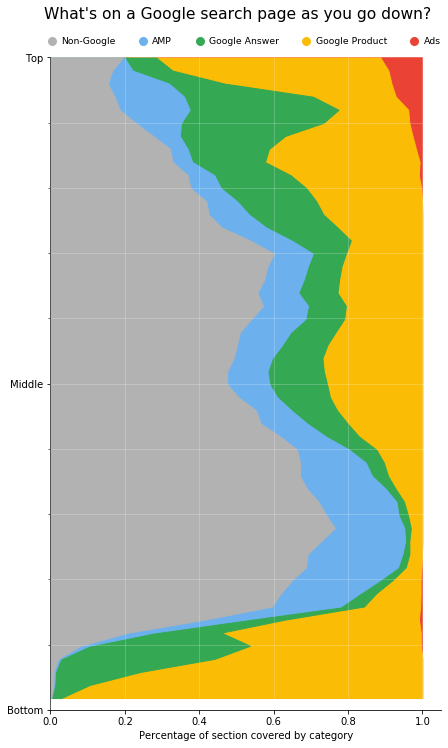

In [56]:
page_section = [i / n_quantiles for i in range(len(cuts.index))]
ig, ax = plt.subplots(figsize=(7, 12))

data = np.cumsum(cuts.values, axis=1)
for i, col in enumerate(cuts.columns):
    ax.fill_betweenx(page_section, 
                     data[:, i], 
                     label=col[-1], 
                     color=colors[i],
                     zorder=-i)
ax.margins(y=0)
ax.set_xlim(0, None)
ax.set_axisbelow(False)
plt.gca().invert_yaxis()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# special ticks for y-axis
ax.set_yticks(np.arange(0, 1.001, 0.0998), minor=True)
plt.yticks(np.arange(0, 1.001, .499),
           ['Top', 'Middle', 'Bottom'])

ax.legend(handles=legend_elements[::-1],
          loc='lower left', 
          bbox_to_anchor= (-0.025, 1.015), ncol=5,
          handletextpad=0.0,
          labelspacing=0, 
          borderaxespad=.1, 
          borderpad=0.1,
          frameon=False,
          prop={'size': 9.2}
         )

plt.title("What's on a Google search page as you go down?",
         x=0.48,
         y=1.05,
         size=15.5)

ax.set_xlabel("Percentage of section covered by category")

ax.grid(which='major', 
        axis='x', 
        linestyle='-',
        alpha=.27,
        zorder=1000, 
        color='white')

ax.grid(which='both', 
        axis='y', 
        linestyle='-',
        alpha=.27,
        zorder=1000, 
        color='white')

plt.savefig(fn_plt)
plt.show();